In [14]:
#Импорт зависимостей
from tensorflow import keras as K
import numpy as np
import string
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
#Разархивируем данные и посмотрим что внутри
!tar -xf aclImdb_v1.tar.gz
print(os.listdir('aclImdb/'))
print(os.listdir('aclImdb/train'))
print(os.listdir('aclImdb/test'))

['README', 'imdb.vocab', 'imdbEr.txt', 'train', 'test']
['urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt', 'labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat']
['urls_neg.txt', 'urls_pos.txt', 'labeledBow.feat', 'neg', 'pos']


In [16]:
#Удалим папку unsup, оставим только pos и neg
shutil.rmtree('aclImdb/train/unsup')

In [77]:
#Константы
BATCH_SIZE = 128
MAX_FEATURES = 25000
EMBEDDING_DIM = 256
SEQUENCE_LENGTH = 1000
EPOCHS = 10

In [78]:
#Создадим дадасет для обучения
raw_train_ds = K.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size = BATCH_SIZE,
        seed = 1,
        validation_split=0.2,
        subset="training",
        )

raw_val_ds = K.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = BATCH_SIZE,
    seed = 1,
    validation_split = 0.2,
    subset = "validation",
    )

raw_test_ds = K.preprocessing.text_dataset_from_directory(
        "aclImdb/test",
        batch_size = BATCH_SIZE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [79]:
#Посмотрим на один элемент батча
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(1):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'Stupid and just plain weird movie about some kid who becomes traumatized when he finds out Santa isn\'t real (???). He grows up and becomes an adult (Brandon Maggart) who makes lists of people who are naughty or nice. One Christmas he snaps and sets out to kill the naughty people--dressed as Santa of course.<br /><br />Boring and just plain bad killer Santa movie. If you\'re looking for gore, it\'s not here. Only a few of the murders are shown and they\'re not that gory with VERY fake effects. Most of the movie just contains Brandon Maggart talking to himself and slowly going crazy. The script is trite, the acting is terrible and it leads to an ending which had me staring slack-jawed at the TV. Seriously, I had to rewind the tape and watch it again to make sure I wasn\'t hallucinating! Really REALLY poor ending.<br /><br />If you want a scary Christmas flick rent "Black Christmas" (the original 70s version---NOT the terrible remake). Avoid this one at all costs.'
0


In [80]:
#Создадим слой векторизации, который переводит текст в вектор.
#Приведем все слова к нижнему регистру, уберем пунктуацию
vectorize_layer = K.layers.TextVectorization(
                standardize = 'lower_and_strip_punctuation',
                max_tokens = MAX_FEATURES,
                output_mode = 'int',
                output_sequence_length = SEQUENCE_LENGTH)

text_ds = raw_train_ds.map(lambda x, y: x) #Удалим класс, оставим только текст
vectorize_layer.adapt(text_ds)

In [81]:
#В случае, если на конец эпохи точность будет выше 97% или
#валидационный лосс прекратит расти, закончим обучение
class myCallback(K.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True
mycallback = myCallback()
earlystop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#сохраним лучшую модель
checkpointer = K.callbacks.ModelCheckpoint(filepath="export_model",
                                                  monitor="val_loss",
                                                  verbose=0,
                                                  save_best_only=True)

In [82]:
#Создадим модель
model = K.Sequential(
    [
        K.Input(shape=(1,), dtype="string"),
        vectorize_layer,
        K.layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),
        K.layers.Dropout(0.5),
        K.layers.Bidirectional(K.layers.LSTM(64, return_sequences=True)),
        K.layers.Bidirectional(K.layers.LSTM(64,)),
        K.layers.Dense(128, activation="relu"),
        K.layers.Dropout(0.5),
        K.layers.Dense(1, activation="sigmoid", name="predictions"),
    ])

In [83]:
#Скомпилируем ее
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"],
             )

In [84]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 1000)             0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 1000, 256)         6400000   
                                                                 
 dropout_11 (Dropout)        (None, 1000, 256)         0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 1000, 128)        164352    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                      

In [85]:
#Запустим обучение
history = model.fit(raw_train_ds,
                    validation_data= raw_val_ds,
                    epochs = EPOCHS,
                    callbacks = [mycallback,earlystop,checkpointer])

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.5406 - acc: 0.7225

INFO:tensorflow:Assets written to: export_model/assets


INFO:tensorflow:Assets written to: export_model/assets


157/157 [==============================] - 145s 876ms/step - loss: 0.5406 - acc: 0.7225 - val_loss: 0.3915 - val_acc: 0.8404
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 0.3033 - acc: 0.8845

INFO:tensorflow:Assets written to: export_model/assets


INFO:tensorflow:Assets written to: export_model/assets


157/157 [==============================] - 135s 857ms/step - loss: 0.3033 - acc: 0.8845 - val_loss: 0.3558 - val_acc: 0.8492
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.1781 - acc: 0.9375

INFO:tensorflow:Assets written to: export_model/assets


INFO:tensorflow:Assets written to: export_model/assets


157/157 [==============================] - 135s 858ms/step - loss: 0.1781 - acc: 0.9375 - val_loss: 0.3350 - val_acc: 0.8748
Epoch 4/10
157/157 [==============================] - 103s 657ms/step - loss: 0.1036 - acc: 0.9669 - val_loss: 0.4524 - val_acc: 0.8680
Epoch 5/10
157/157 [==============================] - ETA: 0s - loss: 0.0729 - acc: 0.9776
Reached 97.0% accuracy so cancelling training!
157/157 [==============================] - 103s 656ms/step - loss: 0.0729 - acc: 0.9776 - val_loss: 0.5480 - val_acc: 0.8522


In [73]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

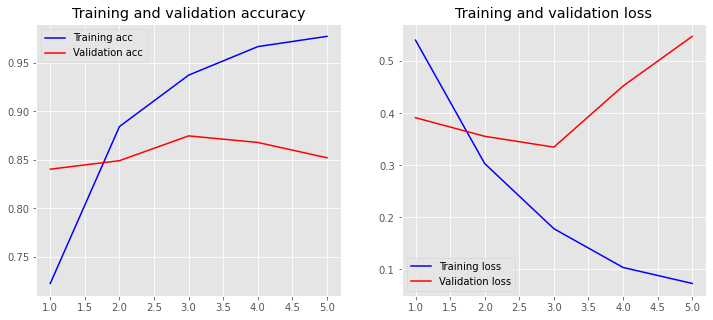

In [86]:
plot_history(history)

In [87]:
#Оценим работу модели на тестовом датасете
loaded_model = K.models.load_model('export_model')
loaded_model.evaluate(raw_test_ds)

196/196 [==============================] - 45s 220ms/step - loss: 0.4038 - acc: 0.8517


[0.40376877784729004, 0.8516799807548523]

In [76]:
#Посмотрим на одном примере
for text_batch, label_batch in raw_train_ds.take(1):
    pred = model.predict(text_batch)
    for i in range(1):
        print(f'Review:{text_batch.numpy()[i]}')
        print(f'True label:{label_batch.numpy()[i]}')
        print(f'Predict label:{pred[i][0]>=0.5}')

Review:b'I recently watched the first Guinea Pig film, The Devil\'s Experiment, and I must admit to being disappointed.<br /><br />This film is invariably included in any list of the "nastiest" films and maybe I was expecting more because of the hype. The truth is though, I don\'t rate it.<br /><br />If I\'d been watching it believing the opening text to be true ("I found this tape..."), I might have been a bit disturbed by it, thinking it was real. Even without the benefit of knowing it not to be real though, I think I\'d have worked out that it indeed wasn\'t.<br /><br />Throughout the film, the girl\'s reactions to what is being done to her just aren\'t what they should be. She should be screaming like a banshee in pain. The fact that she isn\'t means that it\'s obviously not real. I wouldn\'t want to watch it if it were real but if she were to be more convincing in her acting, the film would be more disturbing.<br /><br />And then there are the notorious scenes: nothing affected me